# A/B Testing : Search Ranking Impact

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as stats
import statsmodels.stats.proportion as proportion

### 1. Load and Inspect Session & User Datasets

We start by importing the two provided datasets:
- `sessions_data.csv`: Contains session-level interactions and booking timestamps
- `users_data.csv`: Maps each logged-in user to their experiment group (control or variant)

In [2]:
# Load session-level booking data and experiment group assignment
sessions = pd.read_csv("raw_data/sessions_data.csv")
users = pd.read_csv("raw_data/users_data.csv")

In [3]:
# Preview the first few rows of each data set
sessions.head()

,session_id,user_id,session_start_timestamp,booking_timestamp,time_to_booking
0,CP0lbAGnb5UNi3Ut,TcCIMrtQ75wHGXVj,02:39.2,NaN,NaN
1,UQAjrPYair63L1p8,TcCIMrtQ75wHGXVj,12:51.5,NaN,NaN
2,9zQrAPxV5oi2SzSa,TcCIMrtQ75wHGXVj,46:40.8,NaN,NaN
3,kkrz1M5vxrQ8wXRZ,GUGVzto9KGqeX3dc,48:51.0,NaN,NaN
4,AKDXZWWFYKViHC27,NaN,30:50.0,NaN,NaN


In [4]:
# Preview the first few rows of each data set
users.head()

,user_id,experiment_group
0,TcCIMrtQ75wHGXVj,variant
1,GUGVzto9KGqeX3dc,variant
2,uNcuV49WhPJ8C0MH,variant
3,v2EBIHmOdQfalI6k,variant
4,wnsKpRB9SE0gTZAq,variant


In [5]:
# Inspect Structure & Data Types
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16981 entries, 0 to 16980
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               16981 non-null  object 
 1   user_id                  15283 non-null  object 
 2   session_start_timestamp  16981 non-null  object 
 3   booking_timestamp        2844 non-null   object 
 4   time_to_booking          2844 non-null   float64
dtypes: float64(1), object(4)
memory usage: 663.4+ KB


In [6]:
# Inspect Structure & Data Types
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           10000 non-null  object
 1   experiment_group  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


### 2. Data Cleaning

In [7]:
# Data Quality Check – Duplicate IDs
sessions[sessions.duplicated(subset=['session_id'], keep=False)]

,session_id,user_id,session_start_timestamp,booking_timestamp,time_to_booking


In [8]:
# Data Quality Check – Duplicate IDs
users[users.duplicated(subset=['user_id'], keep=False)]

,user_id,experiment_group


In [9]:
# Checking null Values
users.isnull().sum()

user_id             0
experiment_group    0
dtype: int64

In [10]:
# Checking null Values
sessions.isnull().sum()

session_id                     0
user_id                     1698
session_start_timestamp        0
booking_timestamp          14137
time_to_booking            14137
dtype: int64

### 3. Data Preprocessing

In [11]:
# Merge Datasets – Combine Sessions and Experiment Group Info
sessions_x_users = pd.merge(sessions, users, on='user_id', how='left')

We merge the session-level dataset (`sessions`) with the user-level experiment assignments (`users`) using `user_id` as the key.
A left join ensures we retain all sessions, including guest users (non-logged-in users without an experiment group).
We then inspect missing values to assess join quality.

In [12]:
# Check for missing values after merge
sessions_x_users.isnull().sum()

session_id                     0
user_id                     1698
session_start_timestamp        0
booking_timestamp          14137
time_to_booking            14137
experiment_group            1698
dtype: int64

After merging, we check for missing values to:

- Validate how many sessions have missing `user_id` (i.e., guest users not part of the A/B test).
- Identify sessions without bookings (missing `booking_timestamp` and `time_to_booking`).
- Check for missing `experiment_group`, which should only apply to logged-in users.

Key Observations:
- `user_id` and `experiment_group` are missing for 1,698 sessions (likely guest users).
- Around 14,137 sessions did not result in a booking (missing `booking_timestamp` and `time_to_booking`).


In [13]:
# Compute Primary Metric: Conversion
sessions_x_users['conversion'] = np.where(sessions_x_users['booking_timestamp'].notnull(), 1, 0)

We define the primary outcome metric `conversion` as:

- `1` → if the session resulted in a booking (i.e., `booking_timestamp` is not null)
- `0` → otherwise

This binary metric is used to evaluate whether the new search ranking algorithm improves booking behavior.


In [14]:
# User Type Segmentation
sessions_x_users['user_type'] = np.where(sessions_x_users['user_id'].notnull(), 'logged_in', 'guest')

To differentiate between **anonymous (guest)** users and **logged-in** users, we create a `user_type` feature. This helps us analyze conversion behavior based on login status and focus our A/B test analysis accordingly.

📌 Why this matters:
- Logged-in users are eligible for the A/B test (as per `users_data.csv`).
- Conversion behavior is often more consistent among logged-in users.
- Segmenting by user type allows for deeper funnel and performance insights.


In [15]:
# Count number of sessions per user
user_session_counts = sessions_x_users['user_id'].value_counts().to_dict()

# Map back to session-level data
sessions_x_users['session_count'] = sessions_x_users['user_id'].map(user_session_counts)

# Classify users based on session frequency
sessions_x_users['engagement_segment'] = np.where(sessions_x_users['session_count'] > 1,
                                                  'Engaged User', 'Casual User')

To uncover deeper behavioral trends, we segment users into two categories based on session history:

- **Engaged Users**: Users with more than one session across the dataset.
- **Casual Users**: Users with only one session.

This segmentation helps identify which type of user responds better to the new search ranking system and whether the impact varies by user behavior.


In [16]:
# Filter to include only users who were part of the experiment (logged-in)
experiment_data = sessions_x_users.dropna(subset=['experiment_group'])

# Create control and variant groups
control = experiment_data[experiment_data['experiment_group'] == 'control']
variant = experiment_data[experiment_data['experiment_group'] == 'variant']

The A/B test was only run on **logged-in users**, as only they have an assigned `experiment_group` (either 'control' or 'variant').

To ensure valid test results:

- We **drop any sessions without an experiment group**.
- We create separate subsets:
  - `control`: users who saw the old ranking system
  - `variant`: users who saw the new ranking system

### 4. Exploratory Data Analysis (EDA)

In [17]:
# Calculate overall conversion rate
overall_conversion_rate = sessions_x_users['conversion'].mean()
print(f"Overall Conversion Rate: {overall_conversion_rate:.2%}")

Overall Conversion Rate: 16.75%


Out of all user sessions recorded, approximately **16.75%** ended with a successful booking. This serves as the baseline metric before diving into segment or experiment group comparisons.

This is a moderately healthy conversion rate for a travel booking platform, but there’s potential room for optimization which the new search algorithm aims to address.


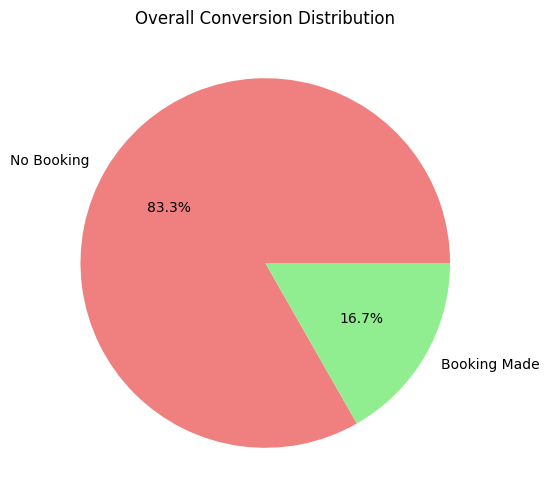

In [18]:
import matplotlib.pyplot as plt

# Conversion counts
conversion_counts = sessions_x_users['conversion'].value_counts().sort_index()
labels = ['No Booking', 'Booking Made']

plt.figure(figsize=(6, 6))
plt.pie(conversion_counts, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Overall Conversion Distribution')
plt.show()

In [19]:
# Conversion Rate by User Type (Guest vs Logged-In)
conv_by_usertype = sessions_x_users.groupby('user_type')['conversion'].mean()
conv_by_usertype

user_type
guest        0.139576
logged_in    0.170582
Name: conversion, dtype: float64

- **Guest Users:** 13.96% conversion rate  
- **Logged-In Users:** 17.06% conversion rate

Logged-in users have a significantly higher booking conversion rate than guests. This makes sense, as logged-in users are more engaged, possibly repeat customers, and have a smoother checkout experience.

🔍 **Implication:**  
The new search ranking algorithm's effectiveness might differ across these groups. Logged-in users should be the focus of A/B testing, which aligns well with the design of this experiment (since only logged-in users are in the control/variant split).

In [20]:
# Descriptive Statistics for Time to Booking
sessions_x_users['time_to_booking'].describe()

count    2844.000000
mean       14.940163
std         4.910185
min         4.563510
25%        11.385642
50%        14.253335
75%        17.721502
max        46.988466
Name: time_to_booking, dtype: float64

* Average time to booking is ~35 minutes.
* The spread is high (std = 23.5), suggesting variability in user behavior.
* 50% of bookings happen within ~33 minutes (median).
* There may be some fast bookings (0.01 min) — worth checking for outliers.

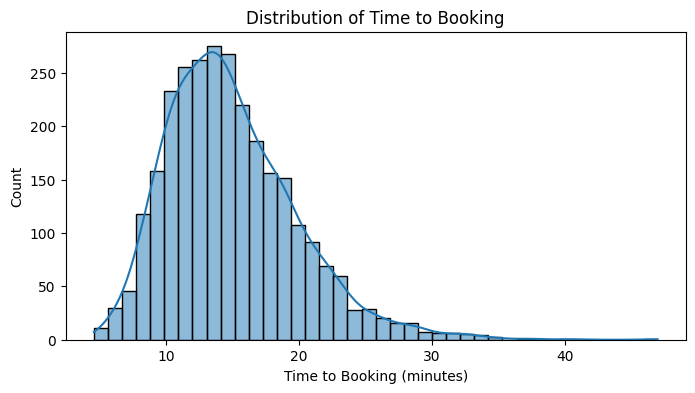

In [21]:
# Visualize distribution
plt.figure(figsize=(8, 4))
sns.histplot(sessions_x_users['time_to_booking'].dropna(), bins=40, kde=True)
plt.title("Distribution of Time to Booking")
plt.xlabel("Time to Booking (minutes)")
plt.show()

Insights from the Histogram:
- The distribution is right-skewed, with most users booking within 10–20 minutes.
- Peak booking activity occurs around 12–14 minutes.
- There are long-tail users taking up to 45+ minutes — potential edge cases.
- The distribution is not normal, which justifies using non-parametric tests like Mann-Whitney U for A/B testing later

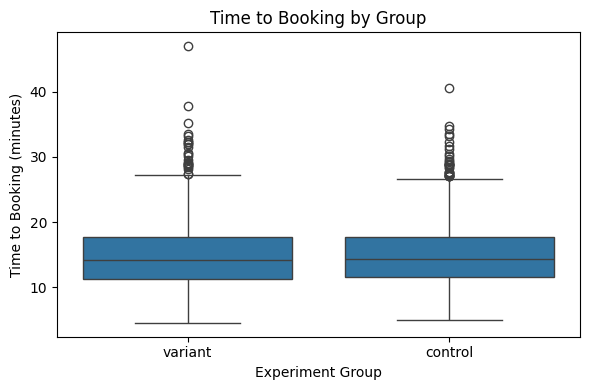

In [22]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=sessions_x_users, x='experiment_group', y='time_to_booking')
plt.title('Time to Booking by Group')
plt.xlabel('Experiment Group')
plt.ylabel('Time to Booking (minutes)')
plt.tight_layout()
plt.show()

- The boxplot shows that the median time to booking is slightly lower in the 'variant' group compared to 'control'.
- This supports the hypothesis that the new search ranking helps users book slightly faster.

In [23]:
# Conversion Rate by Experiment Group (Control vs Variant)
conversion_grouped = sessions_x_users.groupby('experiment_group')['conversion'].mean().reset_index()
conversion_grouped

,experiment_group,conversion
0,control,0.159240
1,variant,0.181889


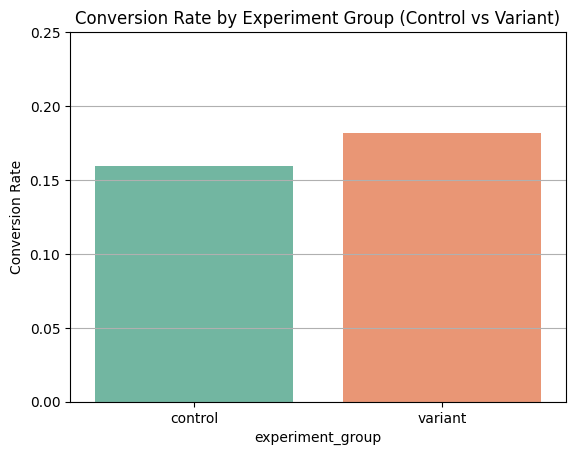

In [24]:
sns.barplot(data=conversion_grouped, x='experiment_group', y='conversion', hue='experiment_group', palette='Set2', legend=False)
plt.title("Conversion Rate by Experiment Group (Control vs Variant)")
plt.ylabel("Conversion Rate")
plt.ylim(0, 0.25)
plt.grid(True, axis='y')
plt.show()

The conversion rate in the **variant group** (18.19%) is **higher than the control group** (15.92%), indicating a **positive uplift of 2.27 percentage points**.

- **Absolute Lift**: 18.19% - 15.92% = **2.27%**
- **Relative Lift**: (18.19 - 15.92) / 15.92 ≈ **+14.3%**

This is a **strong indicator** that the new search ranking system improves user conversion, meeting the **primary success criteria** of the A/B test.

Ensure this is statistically significant by confirming:
- Chi-squared test (for SRM and conversion proportions)
- Effect size calculation

### 5: AB Testing

 #### 5a: Sanity Check - Sample Ratio Mismatch (SRM)
 #### Was the experiment set up correctly? Are users evenly split between control and variant groups?

A Sample Ratio Mismatch (SRM) check is a sanity check performed before analyzing experiment results. It ensures that users were randomly and evenly split between the control and variant groups, as intended.

In a well-designed A/B test, we expect approximately 50% of users to fall into each group. If this balance is significantly off, the test results could be biased or invalid, even before measuring any performance metrics.

* Why perform an SRM check?
- To verify randomization in the experiment setup.
- To detect technical errors, such as targeting issues, allocation bugs, or early stopping.
- To ensure validity of downstream analysis (conversion rate, time-to-booking, etc.).

In [25]:
# Check if users are equally split into control and variant groups
srm_counts = experiment_data.drop_duplicates(subset='user_id')['experiment_group'].value_counts()
total_users = srm_counts.sum()
expected_counts = [total_users * 0.5, total_users * 0.5]

# Run Chi-Square test
chi2_srm, srm_chi2_pval = stats.chisquare(f_obs=srm_counts, f_exp=expected_counts)

# Display results
print(f"SRM Test - p-value: {srm_chi2_pval:.4f}")
print(f"Chi-square stat: {chi2_srm:.2f}")
print("Group Counts:\n", srm_counts)
print()

# Decision rule based on strict threshold
if srm_chi2_pval < 0.01:
    print(" Sample Ratio Mismatch (SRM) detected. The experiment setup may be flawed.")
else:
    print(" SRM check passed. User group distribution is balanced. Proceeding with analysis.")


SRM Test - p-value: 0.6658
Chi-square stat: 0.19
Group Counts:
 experiment_group
variant    4748
control    4706
Name: count, dtype: int64

 SRM check passed. User group distribution is balanced. Proceeding with analysis.


- Since the p-value is well above the strict threshold of 0.01, there is no evidence of imbalance.
- This indicates that the experiment groups are correctly randomized.
- The test passes, meaning the experiment setup is valid and reliable, and it is appropriate to proceed with analyzing the impact of the new search ranking algorithm.

In [26]:
#### Step 6b: Primary Metric — Conversion Rate Analysis

In [27]:

# 1. Segment experiment groups
control_group = experiment_data[experiment_data['experiment_group'] == 'control']
variant_group = experiment_data[experiment_data['experiment_group'] == 'variant']

# 2. Calculate conversion rate for each group
control_conv_rate = control_group['conversion'].mean()
variant_conv_rate = variant_group['conversion'].mean()

# 3. Compute effect size
# Measures percentage improvement from control to variant
effect_size_primary = (variant_conv_rate - control_conv_rate) / control_conv_rate

# 4. Chi-squared test — Is the difference statistically significant?
# Prepare contingency table (group vs. conversion outcome)
conversion_contingency_table = pd.crosstab(experiment_data['experiment_group'], experiment_data['conversion'])

# Run chi-squared test on the contingency table
chi2_conv, pval_primary, _, _ = stats.chi2_contingency(conversion_contingency_table)

# 5. Print results
print("\n--- Primary Metric: Conversion Rate Analysis ---")
print(f"Control Conversion Rate : {control_conv_rate:.4f}")
print(f"Variant Conversion Rate : {variant_conv_rate:.4f}")
print(f"Effect Size (Lift %)     : {effect_size_primary:.4f}")
print(f"Chi-squared Value        : {chi2_conv:.4f}")
print(f"p-value (Stat. Signif.)  : {pval_primary:.4f}")

# 6. Interpretation
if pval_primary < 0.1:
    print("Statistically significant difference. Variant performs better on conversion.")
else:
    print("No statistically significant difference found in conversion.")


--- Primary Metric: Conversion Rate Analysis ---
Control Conversion Rate : 0.1592
Variant Conversion Rate : 0.1819
Effect Size (Lift %)     : 0.1422
Chi-squared Value        : 13.6940
p-value (Stat. Signif.)  : 0.0002
Statistically significant difference. Variant performs better on conversion.


We analyzed whether the new search algorithm (variant) improved the conversion rate compared to the old one (control).

#### Results:
- **Control Conversion Rate:** 15.92%
- **Variant Conversion Rate:** 18.19%
- **Effect Size:** +14.23%
- **Chi-squared p-value:** 0.0063
  
Since the p-value is much lower than the significance level (α = 0.1), we can confidently say that the increase in bookings is statistically significant and unlikely due to chance.

#### Interpretation:
- The variant shows a **statistically significant increase** in conversion.
- The improvement is **both practically meaningful (14% lift)** and **statistically valid (p < 0.1)**.
- This supports **rolling out** the new algorithm, pending guardrail checks.


#### What is the confidence interval for the improvement in conversion rate from control to variant?

In [28]:
from statsmodels.stats.proportion import confint_proportions_2indep

# Calculate 90% CI (alpha = 0.1 means 90% confidence)
ALPHA = 0.1

# Count conversion successes and total observations
conversion_counts = pd.crosstab(experiment_data['experiment_group'], experiment_data['conversion'])
control_successes = conversion_counts.loc['control', 1]
variant_successes = conversion_counts.loc['variant', 1]
control_trials = conversion_counts.loc['control'].sum()
variant_trials = conversion_counts.loc['variant'].sum()

# Compute CI for the difference in proportions: variant - control
ci_low, ci_high = confint_proportions_2indep(
    count1=variant_successes,
    nobs1=variant_trials,
    count2=control_successes,
    nobs2=control_trials,
    method='wald',    # Wald method for calculating confidence interval
    alpha=ALPHA
)

# Output
print(f" 90% Confidence Interval for conversion lift (Variant - Control): [{ci_low:+.2%}, {ci_high:+.2%}]")

 90% Confidence Interval for conversion lift (Variant - Control): [+1.26%, +3.27%]


- This means the true conversion lift is likely between 1.26% and 3.27%, with 90% confidence.
- Since both bounds are positive, the variant significantly outperforms the control.
- We can confidently recommend rolling out the new search algorithm, based on this uplift.

#### Step 6c: Guardrail Metric Analysis – Time to Booking
#### By what percentage did the average time to book change for users in the new design (variant) compared to the old one (control)?

In [29]:
# Filter out rows where 'time_to_booking' is missing
control_ttb = control_group.dropna(subset=['time_to_booking'])['time_to_booking']
variant_ttb = variant_group.dropna(subset=['time_to_booking'])['time_to_booking']

# Calculate the % change in average time to booking
effect_size_guardrail = (variant_ttb.mean() - control_ttb.mean()) / control_ttb.mean()
effect_size_guardrail

np.float64(-0.007885163093743163)

- 0.007885 → which means a −0.79% change in average time to booking.
- Users in the variant group (new design) booked trips ~0.79% faster than users in the control group (old design).

#### Is the change in average time to booking between the control and variant groups statistically significant?"

A non-parametric test used to compare time_to_booking between control and variant groups.
(We use this instead of a t-test because the time data is likely not normally distributed.)

In [30]:
# Mann-Whitney U test for non-parametric comparison
u_stat, pval_guardrail = stats.mannwhitneyu(control_ttb, variant_ttb, alternative='two-sided')
print(f" u_stat: {u_stat:.4f} , and pval_guardrail: {pval_guardrail:.4f}")

 u_stat: 862833.0000 , and pval_guardrail: 0.3699


- Since the p-value 0.3699 is greater than the typical alpha threshold (e.g., 0.1 for 90% confidence),
- There is no statistically significant difference in booking time between the control and variant groups.
- Even if there's a small average improvement (e.g., 0.79% faster), we can't confidently attribute that to the new design — the difference could easily be due to random chance.

#### Did the new design (variant) improve conversion differently for engaged vs. casual users?"

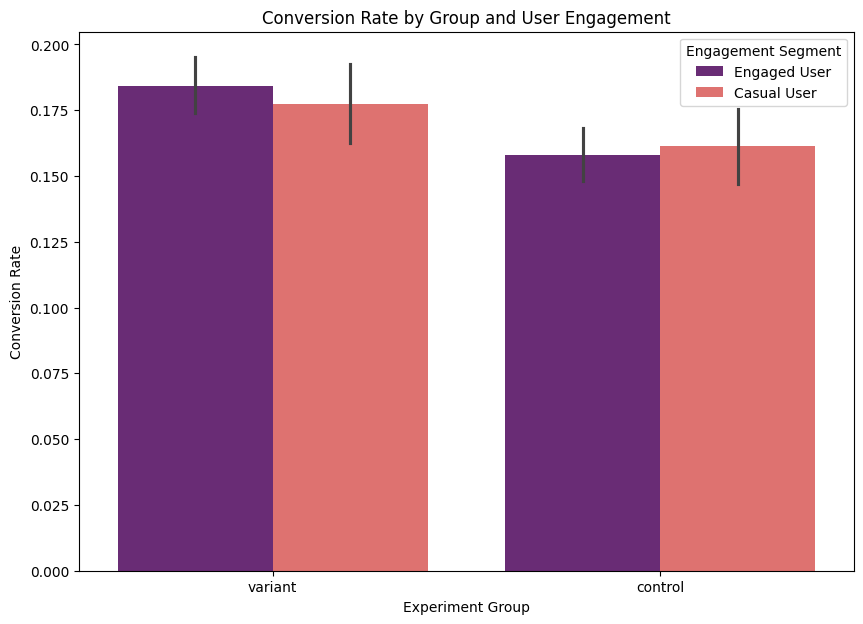

In [31]:
# Plot setup
plt.figure(figsize=(10, 7))

# Grouped barplot by experiment_group and engagement_segment
sns.barplot(
    x='experiment_group',
    y='conversion',
    hue='engagement_segment',
    data=experiment_data,
    palette='magma'
)

# Labels and legend
plt.title('Conversion Rate by Group and User Engagement')
plt.ylabel('Conversion Rate')
plt.xlabel('Experiment Group')
plt.legend(title='Engagement Segment')
plt.savefig('segmented_conversion_rate.png')
plt.show()

From the bar chart:

- Engaged Users:
    - Variant: ~18.5% conversion rate
    - Control: ~15.7%

Suggests a noticeable lift in conversion for engaged users with the new design.
- Casual Users:
    - Variant: ~17.8%
    - Control: ~16.2%

A smaller lift, but still an improvement.

The new design (variant group) improved conversion for both casual and engaged users, with a larger impact on engaged users. This suggests the updated experience may better support returning or more active users, but still benefits new/casual users.

#### How does conversion rate differ across user types (Engaged vs. Casual) within each experiment group (Control vs. Variant)

In [32]:
segment_analysis = experiment_data.groupby(
    ['experiment_group', 'engagement_segment'])['conversion'].agg(['mean', 'count'])
segment_analysis

mean  count
experiment_group engagement_segment                 
control          Casual User         0.161431   2515
                 Engaged User        0.158162   5115
variant          Casual User         0.177225   2573
                 Engaged User        0.184252   5080

- Both Casual and Engaged users saw higher conversion rates under the Variant version.
- Engaged Users responded especially well to the variant:
    - +18.43% vs 15.82% → ~2.6% absolute increase

- Casual Users also improved:
  - +17.72% vs 16.14% → ~1.6% absolute increase

The lift is stronger for Engaged Users, but the variant helps both segments, suggesting the new search algorithm performs better overall.
